# Introduction to Data Science

After the third & fourth sprints (week 5~8), you have learned how to build supervised learning predictive models through two DataCamp courses:
* Supervised Learning with Scikit-Learn
* Machine Learning with Tree Based Models 

And through Jupyter Assignment 3, (sample solutions from Ibrahim is posted on our class sharepoint):
http://myoficommunities/odsc/pythontraining/NY%20Intermediate%20Program/Forms/AllItems.aspx?RootFolder=%2Fodsc%2Fpythontraining%2FNY%20Intermediate%20Program%2FJupyter%20Assignments%2FAssignment%5F3&FolderCTID=0x0120005E98F3492BB28E468945FAA4922BFEA1&View=%7BE489C046%2DAA02%2D4DA6%2D880B%2D0FDC03B2F882%7D

We will continue from Jupyter Assignment 3 sample solutions, let's work on binary classifiers for "Default". 

## Disclaimer:  Limitation of this Jupyter Assignment
* we only work with binary classifiers, not multi-class classifiers, not regressors for numerical predictions;   
* no missing values in features (which is usually unrealistic in real world applications);
* all features are numerical, not categorical;   

please ask yourself what if you are presented with different challenges, while you are doing the practice below.

<span style="color:red">  
Red questions are required, you could find hints from DataCamp
</span>
<span style="color:blue">  
Blue questions are more challenging, which are optional and for in-class open discussion
</span>
<span style="color:green">  
Green questions are most challenging and time consuming, we won't discuss during bi-weekly checkin, but we could discuss during office hours.
</span>

## Key Topics to practice
* Tree based models & other ensemble models;
* model performance metrics for binary classifier;
* hyper parameters tuning (only practice with grid search);
* feature engineering practice and discussion;

## Let's warm up with part of sample solutions from Jupyter Assignment 3 

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,classification_report, accuracy_score, precision_score,
                             recall_score,f1_score, roc_curve, auc)
import platform
import random
from helper_functions import normalize_df_columns

#check versions of libraries and system
display("python |pandas |numpy |seaborn|sklearn|")
display("-------|-------|------|-------|")
display(f"{platform.python_version()}  |{pd.__version__} |{np.__version__}|{sns.__version__}  |{sklearn.__version__}")

df_fdic_small=pd.read_hdf("data_fourth_assignment.h5", key='df').set_index("IDRSSD")
df_fdic_small.columns=normalize_df_columns(df_fdic_small)

main_company_columns=['log_ta','ni_to_ta','equity_to_ta','npl_to_tl','reo_to_ta','alll_to_tl',
                      'core_deposits_to_ta','brokered_deposits_to_ta','liquid_assets_to_ta',
                      'loss_provision_to_tl','nim','assets_growth']
main_market_columns=['term_spread','stock_mkt_growth','real_gdp_growth','unemployment_rate_change',
                     'treasury_yield_3m','bbb_spread','bbb_spread_change']

defaulted_ids=df_fdic_small.query("defaulter==1").index.unique().tolist()
non_defaulted_ids=df_fdic_small.query("defaulter==0").index.unique().tolist()

fdic_defaulted=df_fdic_small.loc[defaulted_ids]
fdic_non_defaulted=df_fdic_small.loc[non_defaulted_ids]

#Determine the number of defaulted entities and print it
number_of_defaulted_entities=len(defaulted_ids)
number_of_nondefaulted_entities=len(non_defaulted_ids)
display(f"The number of defaulted entities in the sample is {number_of_defaulted_entities}")
display(f"The number of non-defaulted entities in the sample is {number_of_nondefaulted_entities}")

#### manually train-test split the data, 70% of IDs in training, and the rest in testing data
defaulted_train_ids = random.sample(defaulted_ids, int(len(defaulted_ids)*0.7))
non_defaulted_train_ids=random.sample(non_defaulted_ids, int(len(non_defaulted_ids)*0.7))
defaulted_test_ids=list(set(defaulted_ids)-set(defaulted_train_ids))
non_defaulted_test_ids=list(set(non_defaulted_ids)-set(non_defaulted_train_ids))

defaulted_train=df_fdic_small.loc[defaulted_train_ids]
non_defaulted_train=df_fdic_small.loc[non_defaulted_train_ids]
defaulted_test=df_fdic_small.loc[defaulted_test_ids]
non_defaulted_test=df_fdic_small.loc[non_defaulted_test_ids]

df_train_X=defaulted_train[main_company_columns+main_market_columns].\
    append(non_defaulted_train[main_company_columns+main_market_columns])
df_test_X=defaulted_test[main_company_columns+main_market_columns].\
    append(non_defaulted_test[main_company_columns+main_market_columns])
df_train_Y=defaulted_train.defaulter.append(non_defaulted_train.defaulter)
df_test_Y=defaulted_test.defaulter.append(non_defaulted_test.defaulter)
#### end of manually train-test split the data

'python |pandas |numpy |seaborn|sklearn|'

'-------|-------|------|-------|'

'3.6.5  |0.23.0 |1.14.3|0.8.1  |0.19.1'

'The number of defaulted entities in the sample is 472'

'The number of non-defaulted entities in the sample is 9384'

## Model Purpose

<span style="color:blue"> 
Task 1 (no need to code):  
Think about the last 20 lines of code from cell above, which is for manually train-test split, with the following two different purposes of building models:   
    (1) for some other institutions (also with IDRSSD as unique ID), we have missing values for the column "defaulter" across the history, and we want to backfill the history for these missing values with predictive models.   
    (2) we want to use this predictive model ongoing in production, to predict "defaulter" in the future for different institutions.    
Any concerns if the purpose is (2), what other train/test split methods you can think of?   
</span>

<span style="color:red">  
Task 2:  
initialize all supervised learning models listed below (with any hyperparameters you like if not specified, or leave it as default):   
    (1) logistic regression (with hyper parameters from Jupyter Assignment 3),   
    (2) decision tree classifier,   
    (3) random forest classifier,   
    (4) gradientboosting classifier,  
    (5) bagging classifier with 50 logistic classifier, which you just initialized,  
    (6) bagging classifier with 50 decision tree classifier, which you just initialized,    
Hints:  DataCamp notes Chapter 1 page 6,  Chapter 3 page 9, 26,  
</span>

In [2]:
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeClassifier

In [3]:
SEED = 123

logistic=LogisticRegression(penalty='l1',tol=1e-6,C=1000.0, solver="liblinear", random_state=SEED)
dt = DecisionTreeClassifier(random_state=SEED)

rf = RandomForestClassifier(random_state=SEED)
gbc = GradientBoostingClassifier(random_state=SEED)
bc_log = BaggingClassifier(base_estimator=logistic, n_estimators=50, n_jobs=-1)
bc_dt = BaggingClassifier(base_estimator=dt, n_estimators=50, n_jobs=-1)

for all these Binary Classifiers, we are interested in model performance as what we did in Jupyter Assignment 3:
    * ROC curve, 
    * confustion matrix, 
    * classification report, 
    * accuracy.

Task 3: 
<span style="color:red">   
complete the "show_performance" function, so the output of cell below is as expected
</span>
<span style="color:blue">   
This roc_plot is defined by ourselves, try to replace by installing & using the library "skplt" as Ibrahim introduced in Jupyter Assignment 3 sample solutions:     
        code Hint:    
    import skplt  
    skplt.metrics.plot_roc(df_test_Y, result_all.predict_proba(df_test_X))
</span>

In [4]:
def roc_plot(roc_data, auc_data):
    plt.figure()
    lw = 2
    plt.plot(roc_data[0],roc_data[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_data)
    plt.plot([0, 1], [0, 1], lw=lw, color='r', linestyle='--', label='y=x', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
def show_performance(model, df_train_X, df_train_Y, df_test_X, df_test_Y):
    model_fitted = model.fit(df_train_X,df_train_Y)
    predictions_y = model.predict(df_test_X)
    predictions_y_proba = model.predict_proba(df_test_X)
    roc_data = roc_curve((df_test_Y==0), predictions_y_proba[:,0])
    auc_data = auc(roc_data[0], roc_data[1])
    roc_plot(roc_data, auc_data)   
    print("confusion mastrix:")
    print(confusion_matrix(df_test_Y,predictions_y))
    print("classification report:")
    print(classification_report(df_test_Y,predictions_y))
    print("accuracy score:")
    print(accuracy_score(df_test_Y,predictions_y))

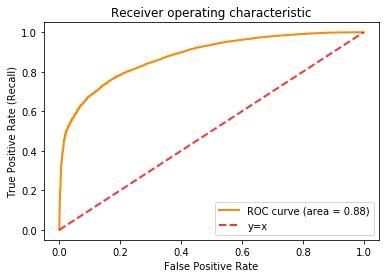

confusion mastrix:
[[127363    188]
 [  4245    447]]
classification report:
             precision    recall  f1-score   support

          0       0.97      1.00      0.98    127551
          1       0.70      0.10      0.17      4692

avg / total       0.96      0.97      0.95    132243

accuracy score:
0.9664783769273232


In [6]:
# _ = show_performance(logistic, df_train_X, df_train_Y, df_test_X, df_test_Y)
# _ = show_performance(dt, df_train_X, df_train_Y, df_test_X, df_test_Y)
# _ = show_performance(rf, df_train_X, df_train_Y, df_test_X, df_test_Y)
_ = show_performance(gbc, df_train_X, df_train_Y, df_test_X, df_test_Y)
# _ = show_performance(bc_log, df_train_X, df_train_Y, df_test_X, df_test_Y)
# _ = show_performance(bc_dt, df_train_X, df_train_Y, df_test_X, df_test_Y)

<span style="color:red">  
Task 4:  
complete the function "show_features", with output similar like the cell below.    
Think about "Do we need testing data as input into this function?"  
Hints:  DataCamp notes Chapter 3 page 28,  
</span>

In [7]:
def show_features(model, df_train_X, df_train_Y):
    '''input model, training set, display feature importance
    :param model: model object, could be from sklearn
    :param df_train_X:  pandas DataFrame,  containing features
    :param df_train_Y:  pandas DataFrame(1 column) or Series,  containing the response variable
    '''
    model_fitted = model.fit(df_train_X,df_train_Y)
    
    t1 = df_train_X.columns
    t2 = model_fitted.feature_importances_
    scores = pd.DataFrame([t1, t2]).T
    scores.columns = ["feature", "score"]
    scores = scores.sort_values(by="score", ascending=False)
    display(scores.head())
    scores.set_index("feature").iloc[::-1].plot(kind='barh', color='lightgreen')
    plt.show()

,feature,score
2,equity_to_ta,0.0996053
0,log_ta,0.0935536
3,npl_to_tl,0.0882009
6,core_deposits_to_ta,0.0865045
8,liquid_assets_to_ta,0.0853172


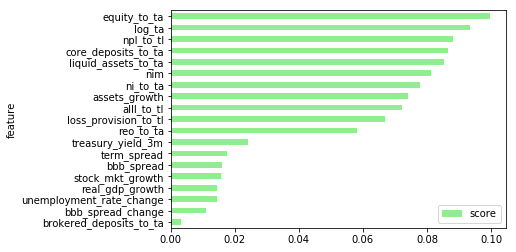

In [8]:
show_features(rf, df_train_X, df_train_Y)

,feature,score
0,log_ta,0.171127
10,nim,0.110484
6,core_deposits_to_ta,0.107205
2,equity_to_ta,0.0870888
8,liquid_assets_to_ta,0.0801167


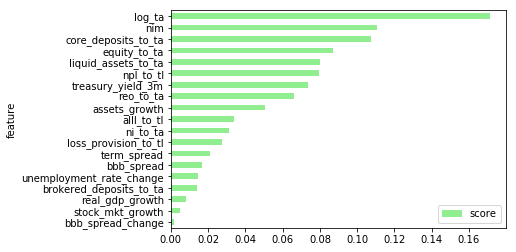

In [9]:
show_features(gbc, df_train_X, df_train_Y)

## Collinearity / Correlated features
let's do feature selection with different tree based models. What if we have highly correlated features?  
you can google and find lots of articles on this topic, here is one example:   
https://datascience.stackexchange.com/questions/12554/does-xgboost-handle-multicollinearity-by-itself

<span style="color:red">  
Task 5:  
the following cell is trying to duplicate one feature "log_ta" ,  please use "show_features" function defined above, to explore feature importance after we add this duplicated feature.   
    you can choose to run "show_features" with decision tree, randomforest and gradientboosting models you intialized above.
</span>
<span style="color:blue">  
(1) If you have experience using linear models to do features (predictors) selection, think about the difference.    
    (Linear models can be linear, lasso, logistic or any generalized linear models. )   
(2) Think about feature importance within different tree based classifiers?  what if regressors instead of binary classifier?  
    Hint: the structure of models, as in DataCamp notes Chapter 3 page 22, Chapter 4 page 5, 14
</span>

In [10]:
df_train_X_added = df_train_X.copy(deep=True)
df_train_X_added["log_ta_mirrored"] = df_train_X_added["log_ta"]

,feature,score
2,equity_to_ta,0.112602
6,core_deposits_to_ta,0.0885162
3,npl_to_tl,0.0858393
10,nim,0.0808796
8,liquid_assets_to_ta,0.0797967


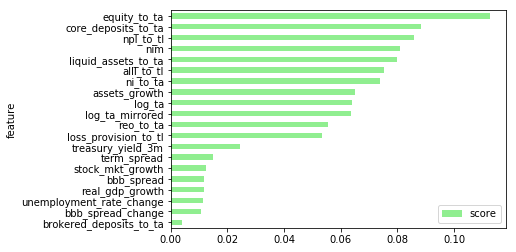

In [11]:
show_features(dt, df_train_X_added, df_train_Y)

,feature,score
2,equity_to_ta,0.0901341
3,npl_to_tl,0.0842632
6,core_deposits_to_ta,0.0815651
8,liquid_assets_to_ta,0.0783497
1,ni_to_ta,0.0774239


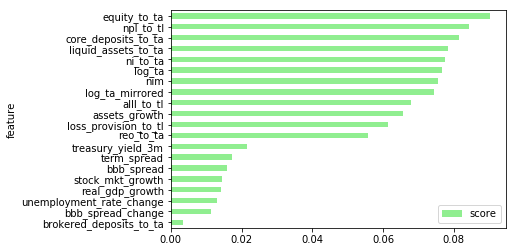

In [12]:
show_features(rf, df_train_X_added, df_train_Y)

,feature,score
10,nim,0.109883
6,core_deposits_to_ta,0.107876
19,log_ta_mirrored,0.0878117
2,equity_to_ta,0.087138
3,npl_to_tl,0.0822908


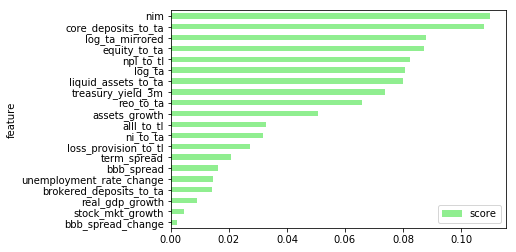

In [13]:
show_features(gbc, df_train_X_added, df_train_Y)

# Consistent with Jupyter Assignment 3, we downsample to make it balanced
the cell below is from sample solutions of Jupyter Assignment 3

In [14]:
#Determine the number of defaulted entities and print it
number_of_defaulted_entities=len(defaulted_ids)
number_of_nondefaulted_entities=len(non_defaulted_ids)
display(f"The number of defaulted entities in the sample is {number_of_defaulted_entities}")
display(f"The number of non-defaulted entities in the sample is {number_of_nondefaulted_entities}")
#Select randomly a sample of non defaulted entities with the same size as the defaulted entities
#print the number of non defaulted entities
non_defaulted_balanced_ids=random.sample(non_defaulted_ids, int(number_of_defaulted_entities*1))
display(f"The number of non-defaulted entities in the balanced dataset is {len(non_defaulted_balanced_ids)}")

#Create the training and test data sets like in Part I but using the limited non-defaulted IDs
non_defaulted_train_balanced_ids=random.sample(non_defaulted_balanced_ids, 
           int(len(non_defaulted_balanced_ids)*0.7))

non_defaulted_test_balanced_ids=list(set(non_defaulted_balanced_ids)-\
                                     set(non_defaulted_train_balanced_ids))

non_defaulted_train_balanced=df_fdic_small.loc[non_defaulted_train_balanced_ids]

non_defaulted_test_balanced=df_fdic_small.loc[non_defaulted_test_balanced_ids]

df_train_balanced_X=defaulted_train[main_company_columns+main_market_columns].\
append(non_defaulted_train_balanced[main_company_columns+main_market_columns])

df_test_balanced_X=defaulted_test[main_company_columns+main_market_columns].\
append(non_defaulted_test_balanced[main_company_columns+main_market_columns])

df_train_balanced_Y=defaulted_train.defaulter.\
    append(non_defaulted_train_balanced.defaulter)

df_test_balanced_Y=defaulted_test.defaulter.\
    append(non_defaulted_test_balanced.defaulter)

'The number of defaulted entities in the sample is 472'

'The number of non-defaulted entities in the sample is 9384'

'The number of non-defaulted entities in the balanced dataset is 472'

<span style="color:red">  
Task 6:  
without tuning hyperparameters, let's use "show_performance" function we defined above, to choose the best model you like. (you need to evaluate the model performance)
</span>

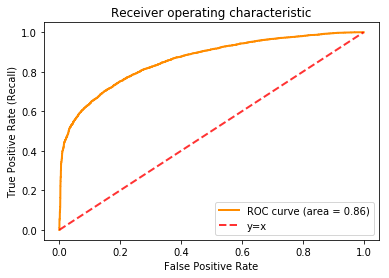

confusion mastrix:
[[4897 1352]
 [1119 3573]]
classification report:
             precision    recall  f1-score   support

          0       0.81      0.78      0.80      6249
          1       0.73      0.76      0.74      4692

avg / total       0.78      0.77      0.77     10941

accuracy score:
0.7741522712731925


In [15]:
# _ = show_performance(logistic, df_train_balanced_X, df_train_balanced_Y, df_test_balanced_X, df_test_balanced_Y)
_ = show_performance(gbc, df_train_balanced_X, df_train_balanced_Y, df_test_balanced_X, df_test_balanced_Y)

# Let's look at gridsearch for hyper parameters tuning only for gradient boosting

<span style="color:red">  
Task 7:  
if we use gradient boosting classifier on balanced data, please try gridsearch to optimize the hyperparameters.  
Use "show_performance" function on this optimized classifier.   
    Hint: DataCamp notes Chapter 5, page 10   
(given that grid search is computing expensive, we don't expect to improve much on your local laptop. and no need to match the output below.) 
</span>   
<span style="color:blue"> what scoring metric you use for searching? </span>

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
params_gbc = {
    'learning_rate': [0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'max_depth': [3,4,5],
    'max_features': range(max(6, df_train_balanced_X.shape[1]-5), df_train_balanced_X.shape[1])
}

In [18]:
grid_gbc = GridSearchCV(estimator=gbc, param_grid=params_gbc, scoring='accuracy', cv=10, n_jobs=-1)
grid_gbc.fit(df_train_balanced_X, df_train_balanced_Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.2], 'n_estimators': [50, 100, 150], 'max_depth': [3, 4, 5], 'max_features': range(14, 19)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [19]:
print(grid_gbc.best_params_)

{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 16, 'n_estimators': 150}


In [20]:
print(grid_gbc.best_estimator_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=16, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False)


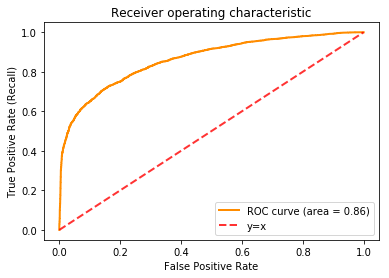

confusion mastrix:
[[4898 1351]
 [1098 3594]]
classification report:
             precision    recall  f1-score   support

          0       0.82      0.78      0.80      6249
          1       0.73      0.77      0.75      4692

avg / total       0.78      0.78      0.78     10941

accuracy score:
0.7761630563933827


In [21]:
_ = show_performance(grid_gbc.best_estimator_, df_train_balanced_X, df_train_balanced_Y, 
                     df_test_balanced_X, df_test_balanced_Y)

# try to extract more features

<span style="color:green">  
Task 8:  
we only use some of the features in our predictive models, as in variables "main_company_columns" & "main_market_columns".  
we could try to extract more features from other columns, (perhaps there is some seasonality pattern of "defaulter"?).  
feature enginnering will require lots of efforts, and may never be perfect,  please feel free to extract more features if you have time..
</span>